<a href="https://colab.research.google.com/github/estebansalas18/clasificador-imagenes/blob/main/balanceo_imagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, Input, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint
#from keras.utils import np_utils
import numpy as np
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import os
import io
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Angus       1000 non-null   object
 1   Beefmaster  1000 non-null   object
 2   Bison       1000 non-null   object
 3   Brahman     1000 non-null   object
 4   Charolais   1000 non-null   object
 5   Guzerat     1000 non-null   object
 6   Holstein    1000 non-null   object
 7   Simmental   1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


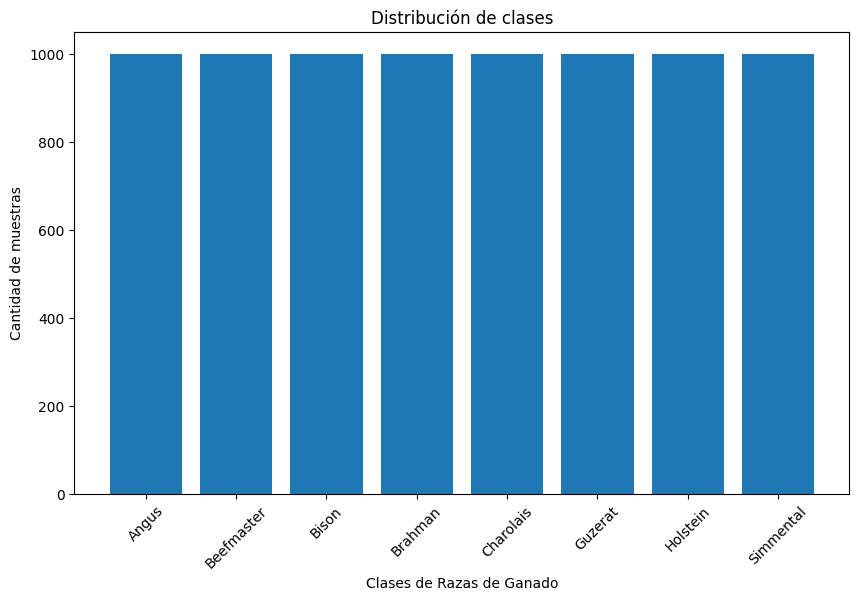

In [4]:
# Directorio base donde se encuentran las imágenes
BASE = '/content/drive/MyDrive/Bovine cattle images'

# Lista de clases de vehiculos
classes = ['Angus', 'Beefmaster', 'Bison', 'Brahman', 'Charolais', 'Guzerat', 'Holstein', 'Simmental']

# Crear un diccionario para almacenar los nombres de archivo de las imagenes
dataset = {}
for cattle in classes:
    dataset[cattle] = [i for i in os.listdir(BASE + '/' + cattle)]

# Crear un DataFrame a partir del diccionario
df_original = pd.DataFrame.from_dict(dataset, orient='index')
df_original = df_original.transpose()

print("DataFrame con clases e imagenes:")
df_original.info()

# Contar la cantidad de muestras por clase en el DataFrame submuestreado
class_counts = df_original.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de Razas de Ganado')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

In [5]:
print(df_original['Angus'])

0       1 (105).jpg
1        1 (16).jpg
2       1 (126).jpg
3       1 (149).jpg
4       1 (100).jpg
           ...     
995    new5-421.jpg
996    new4-611.jpg
997    new4-884.jpg
998    new5-495.jpg
999    new5-256.jpg
Name: Angus, Length: 1000, dtype: object


In [6]:
# Set the path to the augmented images folder
augmented_path = "augmented"

# Create the data generator for augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.5, 1.5],
    fill_mode='nearest'
)

# Iterate over the class folders
for class_folder in ['Angus', 'Beefmaster']:
    BASE_path = os.path.join(BASE, class_folder)
    augmented_class_path = os.path.join(augmented_path, class_folder)
    num_augmented_images = 1000 if class_folder == 'Van' else 400

    # Create the folder for augmented images if it doesn't exist
    os.makedirs(augmented_class_path, exist_ok=True)

    # Get the list of original images in the current class folder
    images = os.listdir(BASE_path)

    # Copy the original images
    # Copy the original images
    for image_name in images:
        original_image_path = os.path.join(BASE_path, image_name)
        augmented_image_path = os.path.join(augmented_class_path, image_name)
        shutil.copy(original_image_path, augmented_image_path)


    # Augment the images to reach the desired number
    augmented_generated = 0 # Control variable

    if num_augmented_images > 0:
        for image_name in images:
            original_image_path = os.path.join(BASE_path, image_name)
            augmented_image_name = "augmented_" + image_name
            augmented_image_path = os.path.join(augmented_class_path, augmented_image_name)
            image = tf.keras.preprocessing.image.load_img(original_image_path)
            image = tf.keras.preprocessing.image.img_to_array(image)
            image = image.reshape((1,) + image.shape)
            # Generate augmented images using the data generator
            batch = datagen.flow(image, batch_size=1, save_to_dir=augmented_class_path, save_prefix="augmented_", save_format='png')
            batch.next()
            augmented_generated += 1
            if augmented_generated == num_augmented_images:
                break

DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Angus       1000 non-null   object
 1   Beefmaster  1000 non-null   object
 2   Bison       1000 non-null   object
 3   Brahman     1000 non-null   object
 4   Charolais   1000 non-null   object
 5   Guzerat     1000 non-null   object
 6   Holstein    1000 non-null   object
 7   Simmental   1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


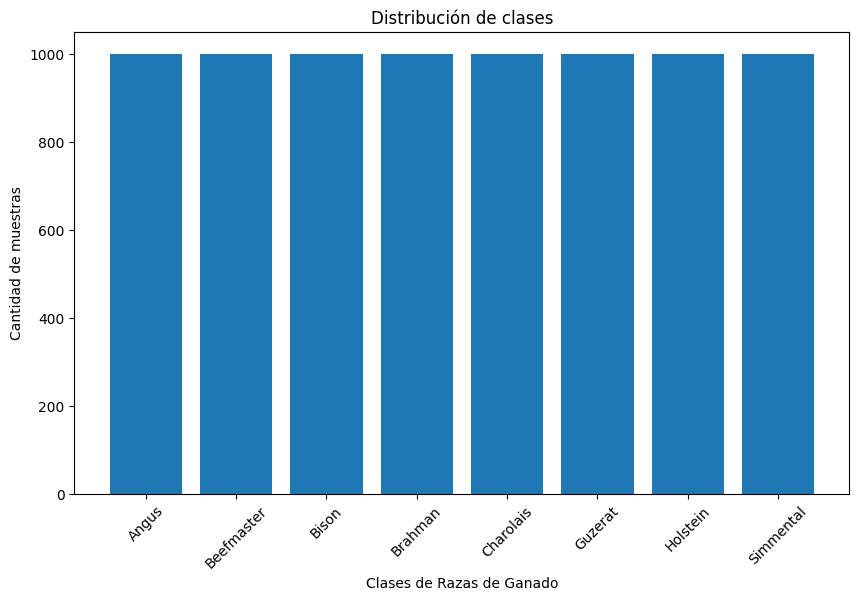

In [12]:
classes = [
    'Angus',
    'Beefmaster',
    'Bison',
    'Brahman',
    'Charolais',
    'Guzerat',
    'Holstein',
    'Simmental'
]

oversampled_data_dict = {}
for cattle in classes:
    oversampled_data_dict[cattle] = [i for i in os.listdir(BASE + '/' + cattle)]

# Crear un DataFrame a partir del diccionario
df_oversampled = pd.DataFrame.from_dict(oversampled_data_dict, orient='index')
df_oversampled = df_oversampled.transpose()

print("DataFrame con clases e imagenes:")
df_oversampled.info()

# Contar la cantidad de muestras por clase en el DataFrame sobremuestreado
class_counts = df_oversampled.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de Razas de Ganado')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

DataFrame con clases e imagenes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Angus       1000 non-null   object
 1   Beefmaster  1000 non-null   object
 2   Bison       1000 non-null   object
 3   Brahman     1000 non-null   object
 4   Charolais   1000 non-null   object
 5   Guzerat     1000 non-null   object
 6   Holstein    1000 non-null   object
 7   Simmental   1000 non-null   object
dtypes: object(8)
memory usage: 62.6+ KB


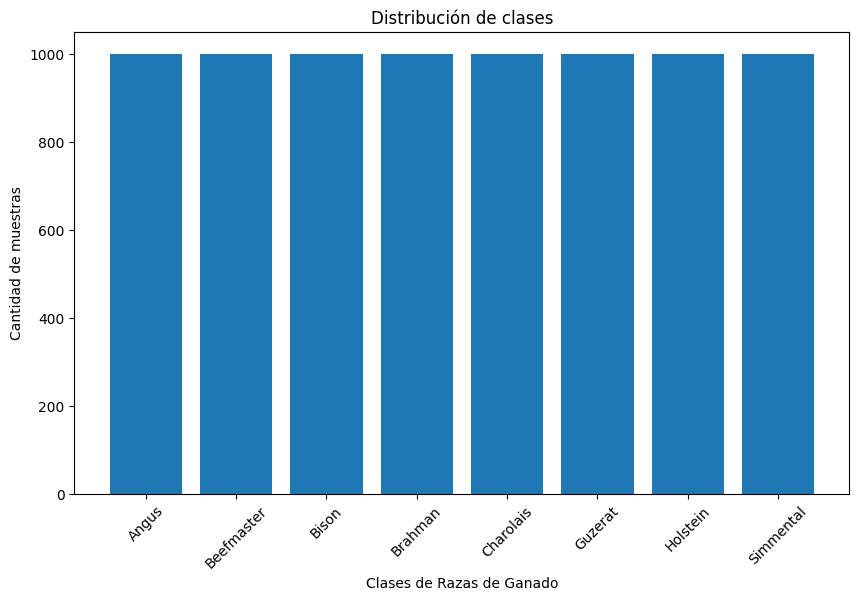

In [13]:
classes = [
    'Angus',
    'Beefmaster',
    'Bison',
    'Brahman',
    'Charolais',
    'Guzerat',
    'Holstein',
    'Simmental'
]

# Crear el diccionario de muestras submuestreadas por clase
undersampled_data_dict = {}
max_samples = 2200 # Obtener el número máximo de muestras en clases desbalanceadas

for cattle in classes:
    class_samples = df_oversampled[cattle].dropna().tolist()
    if len(class_samples) > max_samples:
        random_indices = np.random.choice(len(class_samples), size=max_samples, replace=False)
        class_samples = [class_samples[i] for i in random_indices]
    undersampled_data_dict[cattle] = class_samples

# Crear el DataFrame con las muestras submuestreadas
df = pd.DataFrame.from_dict(undersampled_data_dict, orient='index')
df = df.transpose()

print("DataFrame con clases e imagenes:")
df.info()

# Contar la cantidad de muestras por clase en el DataFrame submuestreado
class_counts = df.count()

# Crear un gráfico de barras para visualizar la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(class_counts.index, class_counts.values)
plt.xlabel('Clases de Razas de Ganado')
plt.ylabel('Cantidad de muestras')
plt.title('Distribución de clases')
plt.xticks(rotation=45)
plt.show()

In [14]:
# Ejemplo de el proceso de submuestreo, en donde se ve que las imagenes se eliminaron aleatoriamente
print(df['Angus'])

0       1 (105).jpg
1        1 (16).jpg
2       1 (126).jpg
3       1 (149).jpg
4       1 (100).jpg
           ...     
995    new5-421.jpg
996    new4-611.jpg
997    new4-884.jpg
998    new5-495.jpg
999    new5-256.jpg
Name: Angus, Length: 1000, dtype: object


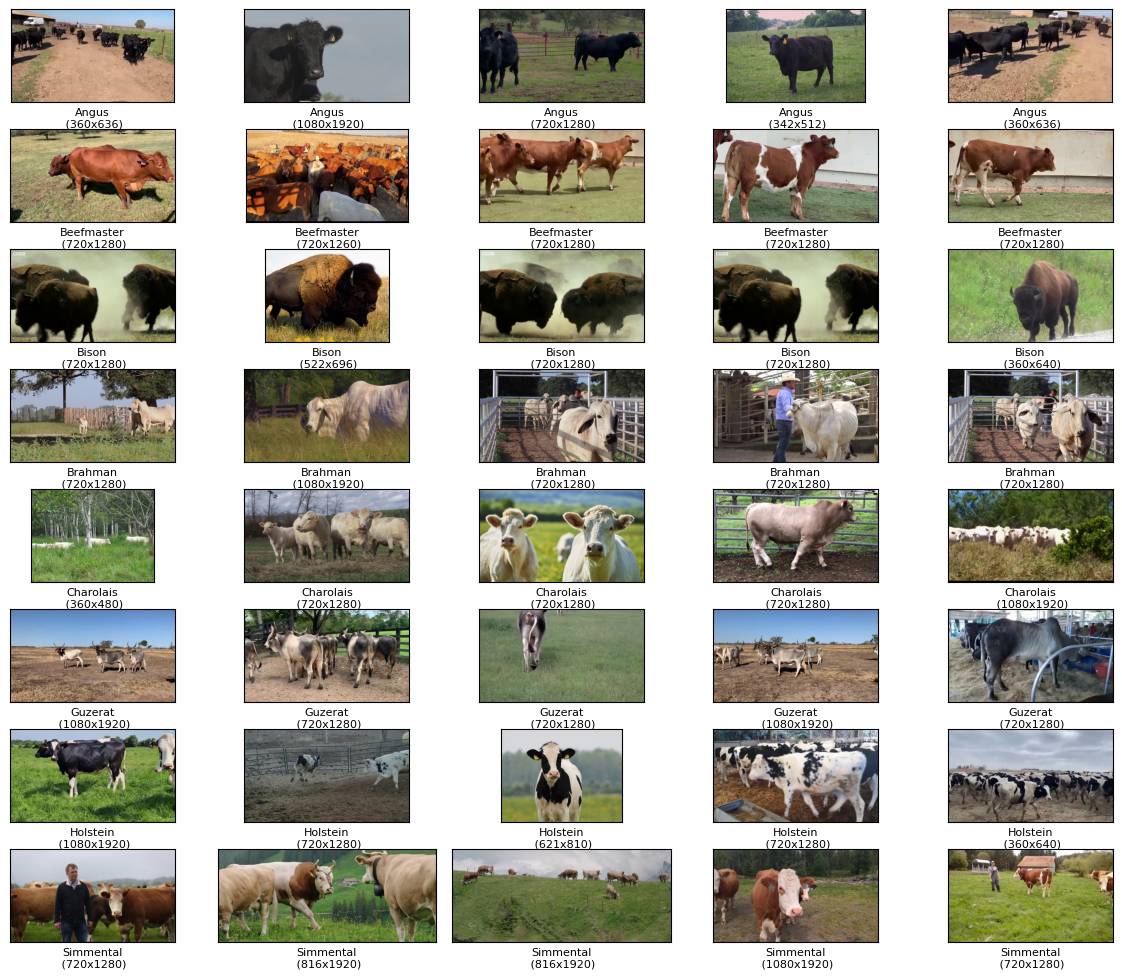

In [19]:
plt.figure(figsize=(12, 12))
for i, cls in enumerate(classes):
    for j in range(5):
        dir = f'/content/drive/MyDrive/Bovine cattle images/{cls}'
        filename = random.choice(df[cls].dropna())
        path = os.path.join(dir, filename)
        img = plt.imread(path)

        # Se añade un espacio entre cada subgráfico para el texto
        plt.subplot(10, 5, i * 5 + j + 1)

        # Se muestra la imagen
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        # Se agrega el texto debajo de la imagen
        plt.xlabel(f'{cls}\n ({img.shape[0]}x{img.shape[1]})', fontsize=8, ha='center')

plt.tight_layout(pad=1.0, h_pad=0, w_pad=0)
plt.show()

